In [384]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import csv

In [345]:
def splitData(data, ratio):
    np.random.shuffle(data)
    train_size = int(len(data) * ratio)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set, test_set

In [346]:
def timeToMinutes(time):
    splitted = time.split(":")
    if int(splitted[0]) > 23 or int(splitted[1]) > 59:
        raise ValueError
    return int(splitted[0]) * 60 + int(splitted[1])

In [347]:
def processTime(time):
    minutes = timeToMinutes(time)
    return  math.sin(minutes / (24 * 60)*math.pi)

In [348]:
def loadData(codesToIndexes):
    data = []
    for i in range(1, 70):
        filePrefix = 'Diabetes-Data/data-'
        if i < 10:
            filePrefix += '0'
        fileHandle = open(filePrefix+str(i), 'r')
        for line in fileHandle:
            line = line.strip()
            if line:
                try:
                    parts = line.split('\t')
                    time = processTime(parts[1])
                    code = int(parts[2])
                    if code not in codesToIndexes.keys():
                        raise ValueError
                    number = int(parts[3])
                    data.append([time, code, number])
                except ValueError:
                    pass
                except IndexError:
                    pass
        
        fileHandle.close()
    return data


In [349]:
def encodeOutput(Y,codesToIndexes):
    Y_encoded = np.zeros((Y.shape[0], 20))
    for i, code in enumerate(Y):
        index = codesToIndexes[code]
        Y_encoded[i, index] = 1
    return Y_encoded

In [350]:
def getEncodedDatasets():
    codesToIndexes = {33:0, 34:1, 35:2, 48:3, 57:4, 58:5, 59:6, 60:7, 61:8, 62:9, 63:10, 64:11, 65:12, 66:13, 67:14, 68:15, 69:16, 70:17, 71:18, 72:19}
    data = np.array(loadData(codesToIndexes))
    train, test = splitData(data, 0.8)
    X_train = train[:, [0, 2]]
    X_test = test[:, [0, 2]]
    Y_train = train[:, 1]
    Y_test = test[:, 1]
    Y_train_encoded = encodeOutput(Y_train,codesToIndexes)
    Y_test_encoded = encodeOutput(Y_test,codesToIndexes)
    return X_test, Y_test_encoded, X_train, Y_train_encoded

In [351]:
def initializeParameters(nX, nH, nY, numberOfHiddenLayers=1):
    parameters = {}
    if numberOfHiddenLayers < 1:
        raise ValueError   
    if numberOfHiddenLayers == 1:
        parameters["W1"] = np.random.randn(nX, nH)
        parameters["b1"] = np.zeros((1,nH))
    if numberOfHiddenLayers > 1:
        parameters["W1"] = np.random.randn(nX, nH[0])
        parameters["b1"] = np.zeros((1,nH[0]))
        for i in range(2, numberOfHiddenLayers+1):
            parameters["W"+str(i)] = np.random.randn(nH[i-2], nH[i-1])
            parameters["b"+str(i)] = np.zeros((1,nH[i-1]))
    if numberOfHiddenLayers == 1:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH, nY)
    else:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH[-1], nY)
    parameters["b"+str(numberOfHiddenLayers+1)] = np.zeros((1,nY))
    return parameters

### Funkcje aktywacji

- **Warstwy ukryte:** Sigmoid
  - $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- **Warstwa wyjściowa:** Softmax
  - $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### Propagacja w przód

Dla każdej warstwy l (od 1 do L+1, gdzie L+1 to warstwa wyjściowa):

1. **Sygnał wejściowy:** $$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
2. **Aktywacja:** 
   - Dla warstw ukrytych: $$A^{[l]} = \sigma(Z^{[l]})$$
   - Dla warstwy wyjściowej: $$A^{[L+1]} = \text{Softmax}(Z^{[L+1]})$$

### Wsteczna propagacja błędu

1. **Błąd na wyjściu (warstwa L+1):**
   - $$\delta^{[L+1]} = A^{[L+1]} - Y$$

Dla każdej warstwy l od L do 1:

2. **Błąd dla warstwy l:**
   - $$\delta^{[l]} = (W^{[l+1]T} \delta^{[l+1]}) \odot \sigma'(Z^{[l]})$$
3. **Gradient dla wag i biasów:**
   - $$\nabla W^{[l]} = \delta^{[l]} A^{[l-1]T}$$
   - $$\nabla b^{[l]} = \sum(\delta^{[l]}, \text{axis} = 0)$$



In [352]:
def costFunction(Y, Y_hat):
    return - np.sum(Y * np.log(Y_hat))

In [353]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [354]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

In [355]:
def propagate(X, Y, parameters):
    # if len(parameters)//2 > 1:            
    A = X
    history = {"A0": X}
    gradients = {}
    for i in range(1, len(parameters)//2+1):
        Z = np.dot(A, parameters["W"+str(i)]) + parameters["b"+str(i)]
        history["Z"+str(i)] = Z
        if i != len(parameters)//2:
            A = sigmoid(Z)
        else:
            A = softmax(Z)
        history["A"+str(i)] = A
    
    cost = costFunction(Y, A)
    gradients = {}
    
    for i in range(len(parameters)//2, 0, -1):
        if i == len(parameters)//2:
            history["dA"+str(i)]= history["A"+str(i)] - Y
        else:
            history["dA"+str(i)] = np.dot(history["dA"+str(i+1)], parameters["W"+str(i+1)].T) * history["A"+str(i)] * (1 - history["A"+str(i)])
        
        gradients["dW"+str(i)] = np.dot(history["A"+str(i-1)].T,history["dA"+str(i)])
        gradients["db"+str(i)] = np.sum(history["dA"+str(i)], axis=0)
    # if len(parameters)//2 == 1:

    #     Z1 = np.dot(X, parameters["W1"]) + parameters["b1"]
    #     A1 = sigmoid(Z1)
    #     Z2 = np.dot(A1, parameters["W2"]) + parameters["b2"]
    #     A2 = softmax(Z2)
    #     cost = costFunction(Y, A2)
    #     # # pochodne funkcji straty:
    #     dA2 = A2 - Y
    #     dW2 = np.dot(A1.T,dA2) 
    #     db2 = np.sum(dA2, axis=0,keepdims=True)
    #     dA1 = np.dot(dA2, parameters["W2"].T)
    #     dZ1 = dA1 * (A1 * (1 - A1))
    #     dW1 = np.dot(X.T, dZ1)
    #     db1 = np.sum(dZ1, axis=0)
    #     gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients, cost


### Aktualizacja wag

- Wagi i biasy są aktualizowane za pomocą metody spadku gradientu:
  - $$W^{[l]} = W^{[l]} - \alpha \nabla W^{[l]}$$
  - $$b^{[l]} = b^{[l]} - \alpha \nabla b^{[l]}$$

In [356]:
def updateParameters(parameters, gradients, learningRate):
    for key in parameters.keys():
        parameters[key] += - learningRate * gradients["d"+key]
    return parameters

In [357]:
def optimize(X, Y, parameters, learningRate, numberOfIterations, printCost=False):
    costs = []
    for i in range(numberOfIterations):
        gradients, cost = propagate(X, Y, parameters)
        parameters = updateParameters(parameters, gradients, learningRate)
        costs.append(cost)
        if i % 100 == 0 and printCost:
            print("Cost after iteration {}: {}".format(i, cost))
    return parameters, costs

In [358]:
def predict(X, parameters):
    Z = X
    for i in range(1, len(parameters)//2):
        Z = np.dot(Z, parameters["W"+str(i)]) + parameters["b"+str(i)]
        Z = sigmoid(Z)
    Z = np.dot(Z, parameters["W"+str(len(parameters)//2)]) + parameters["b"+str(len(parameters)//2)]
    Z = softmax(Z)
    return Z

In [457]:
X_test, Y_test, X_train, Y_train =getEncodedDatasets()
# parameters = initializeParameters(2, [5,15], 20,2)
parameters = initializeParameters(2, 10, 20,1)
params, costs = optimize(X_train,Y_train, parameters, 0.00001, 5000, True)

/tmp/ipykernel_8949/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Cost after iteration 0: 124618.5078081592
Cost after iteration 100: 51237.2650831329
Cost after iteration 200: 47776.02247744379
Cost after iteration 300: 46135.64140408872
Cost after iteration 400: 38854.90892084031
Cost after iteration 500: 36582.455435374075
Cost after iteration 600: 35256.09976441178
Cost after iteration 700: 34423.872154063625
Cost after iteration 800: 33476.02692569133
Cost after iteration 900: 33100.91191764818
Cost after iteration 1000: 32735.564901796894
Cost after iteration 1100: 32440.52359208284
Cost after iteration 1200: 32200.310775425372
Cost after iteration 1300: 32002.415451649893
Cost after iteration 1400: 31837.056420507248
Cost after iteration 1500: 31697.020982048023
Cost after iteration 1600: 31576.915278822038
Cost after iteration 1700: 31472.64278235002
Cost after iteration 1800: 31381.049312122974
Cost after iteration 1900: 31299.672743958334
Cost after iteration 2000: 31226.55722541943
Cost after iteration 2100: 31160.10683005159
Cost after it

In [378]:
def convertYToMaxValuePerRecord(Y):
    return np.argmax(Y, axis=1)

In [379]:
def plot_multiclass_roc(Y, Y_predicted, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = skm.roc_curve(Y[:, i], Y_predicted[:, i])
        roc_auc[i] = skm.auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class: {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

/tmp/ipykernel_8949/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      7525
           1       0.52      0.37      0.43      2920
           2       0.00      0.00      0.00       846
           3       0.00      0.00      0.00      1499
           4       0.00      0.00      0.00       784
           5       0.24      1.00      0.39      2725
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00      2191
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00      2490
          10       0.00      0.00      0.00       170
          11       0.00      0.00      0.00       739
          12       0.26      0.65      0.38       274
          13       0.00      0.00      0.00       132
          14       0.25      0.35      0.30       266
          15       0.00      0.00      0.00        27
          16       0.00      0.00      0.00        58
          17       0.00    

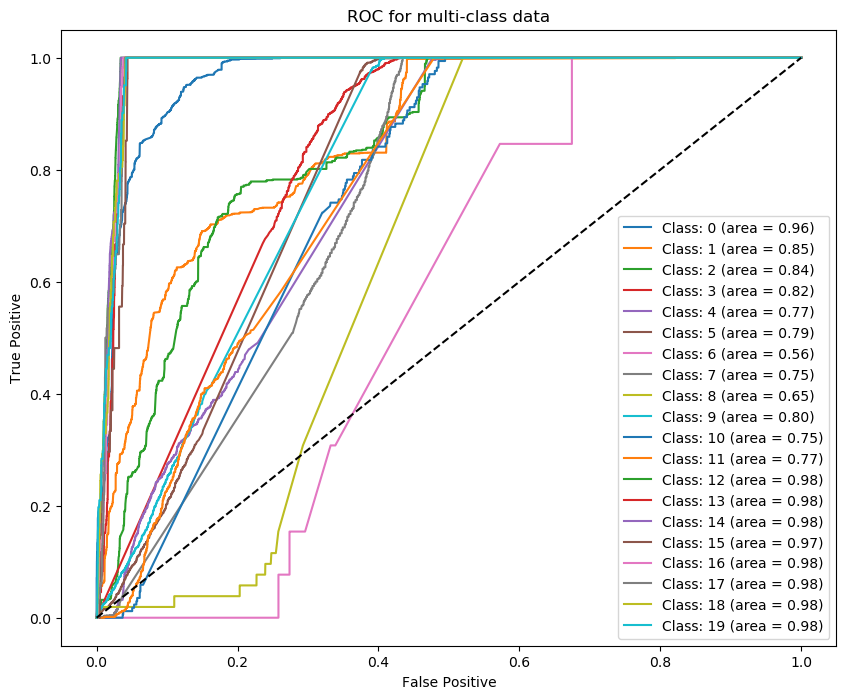

In [458]:
Y_train_predicted = predict(X_train, params)

Y_train_code = convertYToMaxValuePerRecord(Y_train)
Y_train_predicted_code = convertYToMaxValuePerRecord(Y_train_predicted)
trainReport = skm.classification_report(Y_train_code, Y_train_predicted_code)

print(trainReport)
plot_multiclass_roc(Y_train, Y_train_predicted, 20)


In [454]:
Y_test_predicted = predict(X_test, params)

Y_test_code = convertYToMaxValuePerRecord(Y_test)
Y_test_predicted_code = convertYToMaxValuePerRecord(Y_test_predicted)
testReport = skm.classification_report(Y_test_code, Y_test_predicted_code, output_dict=True)

print(testReport)
plot_multiclass_roc(Y_test, Y_test_predicted, 20)


/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.33269531929702456, 'recall': 1.0, 'f1-score': 0.49928189058623845, 'support': 1912.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 713.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 218.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 368.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 193.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 666.0}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 535.0}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11.0}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 650.0}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42.0}, '11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 173.0}, '12': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 

ValueError: Input contains NaN.

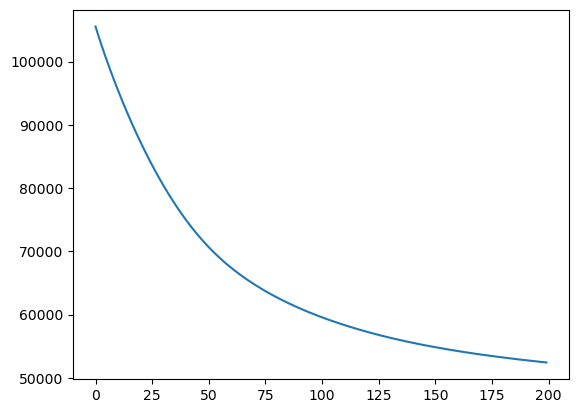

In [382]:
plt.plot(costs)

In [459]:
def writeFileHeader(fileHandle):
    headers = ['Alpha', 'nH', 'Cost', 'Test Accuracy', 'Macro Test Precision', 'Macro Test Recall', 'Macro Test F1-Score', 
        'Macro Test Support','Weighted Test Accuracy', 'Weighted Test Precision', 'Weighted Test Recall', 'Weighted Test F1-Score', 'Weighted Test Support',
        'Train Accuracy', 'Macro Train Precision', 'Macro Train Recall', 'Macro Train F1-Score', 'Macro Train Support',
        'Weighted Train Accuracy', 'Weighted Train Precision', 'Weighted Train Recall', 'Weighted Train F1-Score', 'Weighted Train Support'
    ]
    writer = csv.writer(fileHandle)
    writer.writerow(headers)

In [460]:
def appendRow(filehandle, test, train, alpha, nH, cost):
    row = [
        alpha, nH, cost, 
        test['accuracy'], test['macro avg']['precision'], test['macro avg']['recall'], test['macro avg']['f1-score'], test['macro avg']['support'],
        test['accuracy'], test['weighted avg']['precision'], test['weighted avg']['recall'], test['weighted avg']['f1-score'], test['weighted avg']['support'],
        train['accuracy'], train['macro avg']['precision'], train['macro avg']['recall'], train['macro avg']['f1-score'], train['macro avg']['support'],
        train['accuracy'], train['weighted avg']['precision'], train['weighted avg']['recall'], train['weighted avg']['f1-score'], train['weighted avg']['support']
    ]
    writer = csv.writer(filehandle)
    writer.writerow(row)
    

In [464]:
def runTests():
    X_test, Y_test, X_train, Y_train =getEncodedDatasets()
    alphasToTest = [0.000001,0.00001, 0.0001]
    iterations = 5000
    nX = 2
    nHs = [1,2,5,10,15,20,25,30,100,[5,10],[5,15],[10,20],[20,80],[15,5],[6,10,15]]
    nY = 20
    numbersOfHiddenLayers = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,3]
    if len(nHs) != len(numbersOfHiddenLayers):
        raise ValueError
    with open('results2.csv', 'w', newline='') as fileHandle:
        writeFileHeader(fileHandle)
        for i in range(len(nHs)):
            for alpha in alphasToTest:
                nH = nHs[i]
                numberOfHiddenLayers = numbersOfHiddenLayers[i]
                parameters = initializeParameters(nX, nH, nY,numberOfHiddenLayers)
            
                params, costs = optimize(X_train,Y_train, parameters, alpha, iterations, False)
                Y_train_predicted = predict(X_train, params)
                Y_train_code = convertYToMaxValuePerRecord(Y_train)
                Y_train_predicted_code = convertYToMaxValuePerRecord(Y_train_predicted)
                trainReport = skm.classification_report(Y_train_code, Y_train_predicted_code, output_dict=True)
                Y_test_predicted = predict(X_test, params)
                Y_test_code = convertYToMaxValuePerRecord(Y_test)
                Y_test_predicted_code = convertYToMaxValuePerRecord(Y_test_predicted)
                testReport = skm.classification_report(Y_test_code, Y_test_predicted_code, output_dict=True)
                appendRow(fileHandle, testReport, trainReport, alpha, nH, costs[-1])



In [465]:
runTests()

/tmp/ipykernel_8949/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
/tmp/ipykernel_8949/921653277.py:2: RuntimeWarning: divide by zero encountered in log
  return - np.sum(Y * np.log(Y_hat))
/tmp/ipykernel_8949/921653277.py:2: RuntimeWarning: invalid value encountered in multiply
  return - np.sum(Y * np.log(Y_hat))
/tmp/ipykernel_8949/622319732.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0